### Cosimulation

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

Cite as: Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of  **Cosimulation by Sequential Gaussian Simulation with Collocated Cokriging** with a 2D map example.

* this is the fluctuations in the reproduction of input statistics over multiple simulation realizations.

**YouTube Lecture**: check out my lectures on:

* [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI)
* [Stochastic Cosimulation](https://youtu.be/mvxE0dAT38c?si=P_iJ3SwJBNihwcAA)

For your convenience here's a summary of salient points. First, let's explain the concept of spatial simulation (1 feature).

#### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

#### Cosimulation

There is more than one method to simulate feature together. Each cosimulation method will have a ‘conditioning’ priority:

* **Collocated Cokriging** prioritizes the histogram and variogram and may honor the correlation coefficient between the two variables

* **Cloud transform** will honor the specific form of the bivariate relationship (cloud) between the two features but may not honor the histogram nor the variogram.

These methods start with a completed realization of the secondary feature.

* primary feature is the feature being simulated, secondary feature is the previously simulated feature that is supporting the current simulation.

* for example, porosity is the secondary feature and permeability is the primary feature if we cosimulate a permeability realization constrained by a previously simulated realization of porosity

Note, multiple information sources may be contradictory, in this cases lower priority information is preferentially sacrificed.

* for example, the permeability variogram has a large relative nugget effect, but the porosity realization has no nugget effect and long range spatial continuity, but the correlation between permeability and porosity is very high.

#### Collocated Cokriging

Collocated Cokriging makes two simplifications of full cokriging:

* **Markov Screening** - only one (the collocated) secondary variable is considered
* **Bayesian Updating** - cross covariance $𝐶_{𝑧,𝑦}( \bf{𝐡} )$ is updated from the prior $𝐶_𝑧 (𝐡)$ with the likelihood $𝐶_{𝑧,𝑦}(0) = \rho_{z,y}$ 

In this workflow we simulate porosity and log transform of permeability with:

**Independent Sequential Gaussian Simulation of Two Features** -  each feature simulated separately one at a time
**Sequential Gaussian Simulation with Collocated Cokriging** - simulate a porosity realization and then cosimulate the log transform of permeability given the porosity realization. 

Then we check the relationship between the porosity and log transformed permeability simulated realizations for both cases.

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting major and minor axes.

In [3]:
def add_grid():                                          
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extract a limited sample to reduce data density. This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [5]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df = df.sample(50)                                            # extract 50 samples
df['logPerm'] = np.log(df['Perm'].values)                     # calculate the log of permeability for visualization only
df = df.reset_index()                                         # reset the record index 
df = df[['X','Y','Porosity','Perm','logPerm']]
df['nPorosity'] = geostats.nscore(df=df,vcol='Porosity')[0]   # Gaussian transform the features to calculate correlation
df['nPerm'] = geostats.nscore(df=df,vcol='Perm')[0]
df.head()     

,X,Y,Porosity,Perm,logPerm,nPorosity,nPerm
0,300.0,849.0,0.164065,459.734197,6.130648,1.226528,1.340755
1,470.0,969.0,0.136712,37.116961,3.614074,0.385320,0.553385
2,300.0,800.0,0.164797,497.593578,6.209784,1.340755,1.880794
3,780.0,369.0,0.095566,3.207508,1.165494,-1.036433,-0.612813
4,420.0,809.0,0.131383,43.226512,3.766454,0.176374,0.612813


Let's check the summary statistics to set the plotting minimum and maximum values.

In [6]:
df.describe().transpose()                                     # summary statistics 

,count,mean,std,min,25%,50%,75%,max
X,50.0,466.000000,284.468714,0.000000,220.000000,4.450000e+02,767.500000,940.000000
Y,50.0,494.380000,276.277802,19.000000,244.000000,5.390000e+02,724.000000,969.000000
Porosity,50.0,0.124391,0.032995,0.041122,0.101505,1.246922e-01,0.148787,0.210258
Perm,50.0,89.371422,185.997599,0.120862,2.957486,5.690714e+00,56.663837,931.189014
logPerm,50.0,2.291311,2.262430,-2.113108,1.083190,1.730197e+00,4.026524,6.836462
nPorosity,50.0,-0.002353,1.003124,-2.444022,-0.659071,5.551115e-16,0.659071,2.326348
nPerm,50.0,0.005607,0.984764,-2.046022,-0.659071,5.551115e-16,0.659071,2.326348


#### Plotting and Kriging Parameters

Now we can set these values for kriging and plotting. For brevity we don't cover details on these here.

* we are assuming a simple regular grid
* we are assuming variograms models and kriging search parameters

In [7]:
xmin = 0.0; xmax = 1000.0                                     # spatial limits
ymin = 0.0; ymax = 1000.0

nx = 100; xmn = 5.0; xsiz = 10.0                              # grid specification
ny = 100; ymn = 5.0; ysiz = 10.0

pormin = 0.0; pormax = 0.22
pormean = np.average(df['Porosity'].values)                   # assume representative mean 
permmin = 0.0; permmax = 700.0;
logpermmin = -3.0; logpermmax = 8.0;

nsmin = -3.0; nsmax = 3.0                                     # limits in Gaussian space
#logpermmean = np.average(df['logPerm'].values)               # assume representative mean 

npor_vrange = 300; nperm_vrange = 300

npor_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=npor_vrange,hmin1=npor_vrange) # assumed variograms
nperm_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=nperm_vrange,hmin1=nperm_vrange)

nxdis = 1; nydis = 1; seed = 73073; ndmin = 0; ndmax = 10     # simulation parameters

tmin = -9999.9; tmax = 9999.9                                 # trimming limits, set for no data trimming

Let's look at the data before we simulate. Note, we visualize permeability with a natural log transform to improve interpretation, but all of our workflow steps are conducted in the regular feature space.

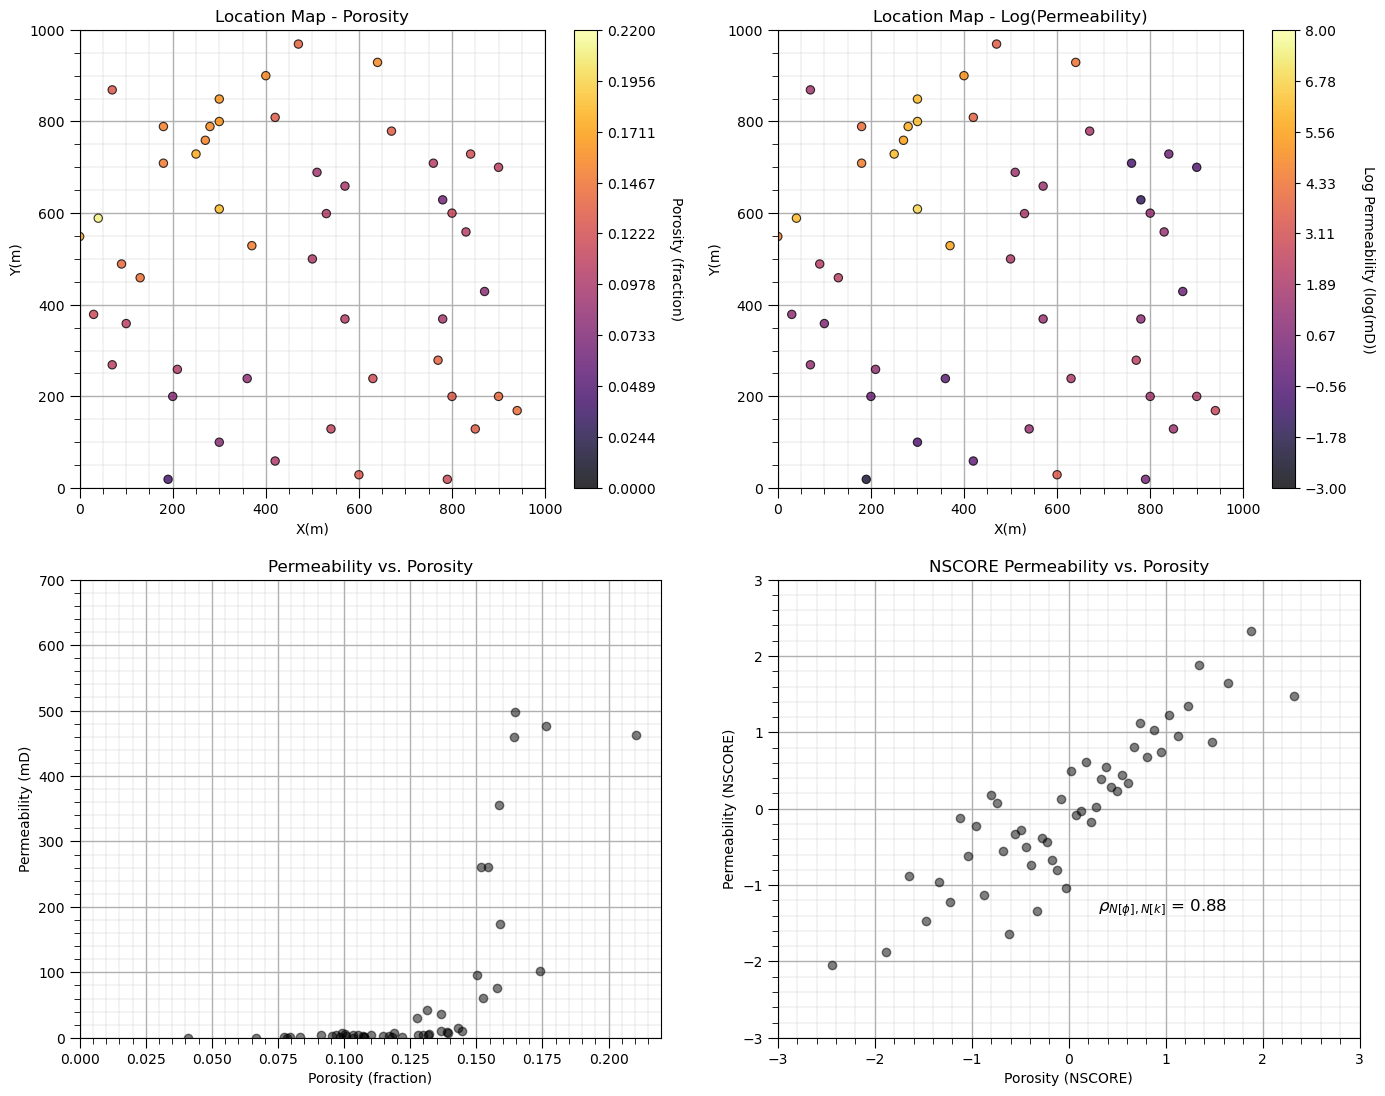

In [8]:
plt.subplot(221)                                              # plot porosity data
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Location Map - Porosity','X(m)','Y(m)',
                'Porosity (fraction)',cmap); add_grid()

plt.subplot(222)                                              # plot log permeability data
GSLIB.locmap_st(df,'X','Y','logPerm',xmin,xmax,ymin,ymax,logpermmin,logpermmax,'Location Map - Log(Permeability)',
                'X(m)','Y(m)','Log Permeability (log(mD))',cmap); add_grid()

plt.subplot(223)                                              # cross plot log permeability and porosity
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=0.5)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax]); add_grid()

plt.subplot(224)                                              # cross plot log permeability and porosity
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=0.5)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Permeability (NSCORE)');plt.title('NSCORE Permeability vs. Porosity')

corr = np.corrcoef(df['nPorosity'].values,df['nPerm'].values)[0,1]
plt.annotate(r'$\rho_{N[\phi],N[k]}$ = ' + str(np.round(corr,2)), (0.3,-1.35),size=12)

plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax]); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Note we have already demonstrated univariate simulation checks for:

* data reproduction at data locations
* histogram reproduction 
* variogram reproduction

in these workflows:

* [kriging vs. simulation](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_kriging_vs_simulation.ipynb)
* [model checking](https://github.com/GeostatsGuy/GeostatsPyDemos/blob/main/GeostatsPy_model_checking.ipynb)

So for brevity, won't repeat these checks here. Also we will just assume reasonable variogram models for demonstration; therefore, no variogram calculation and modeling.

* let's focus on reproduction of the relationship between porosity and permeability

#### Independent Sequential Gaussian Simulation of Two Features

Let's jump right to building two independent simulations and visualizing the results. 

* independently simulate porosity and permeability 
* check the porosity an permeability relationship, the scatter plot.

In [9]:
%%capture --no-display     

sim_por = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seed,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,
            sec_map=0,vario=npor_vario)[0]

sim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=permmin,zmax=permmax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seed+1,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,
            sec_map=0,vario=nperm_vario)[0]

Visualize porosity and permeability realizations and the porosity vs. permeability relationship for independently simulation realizations.

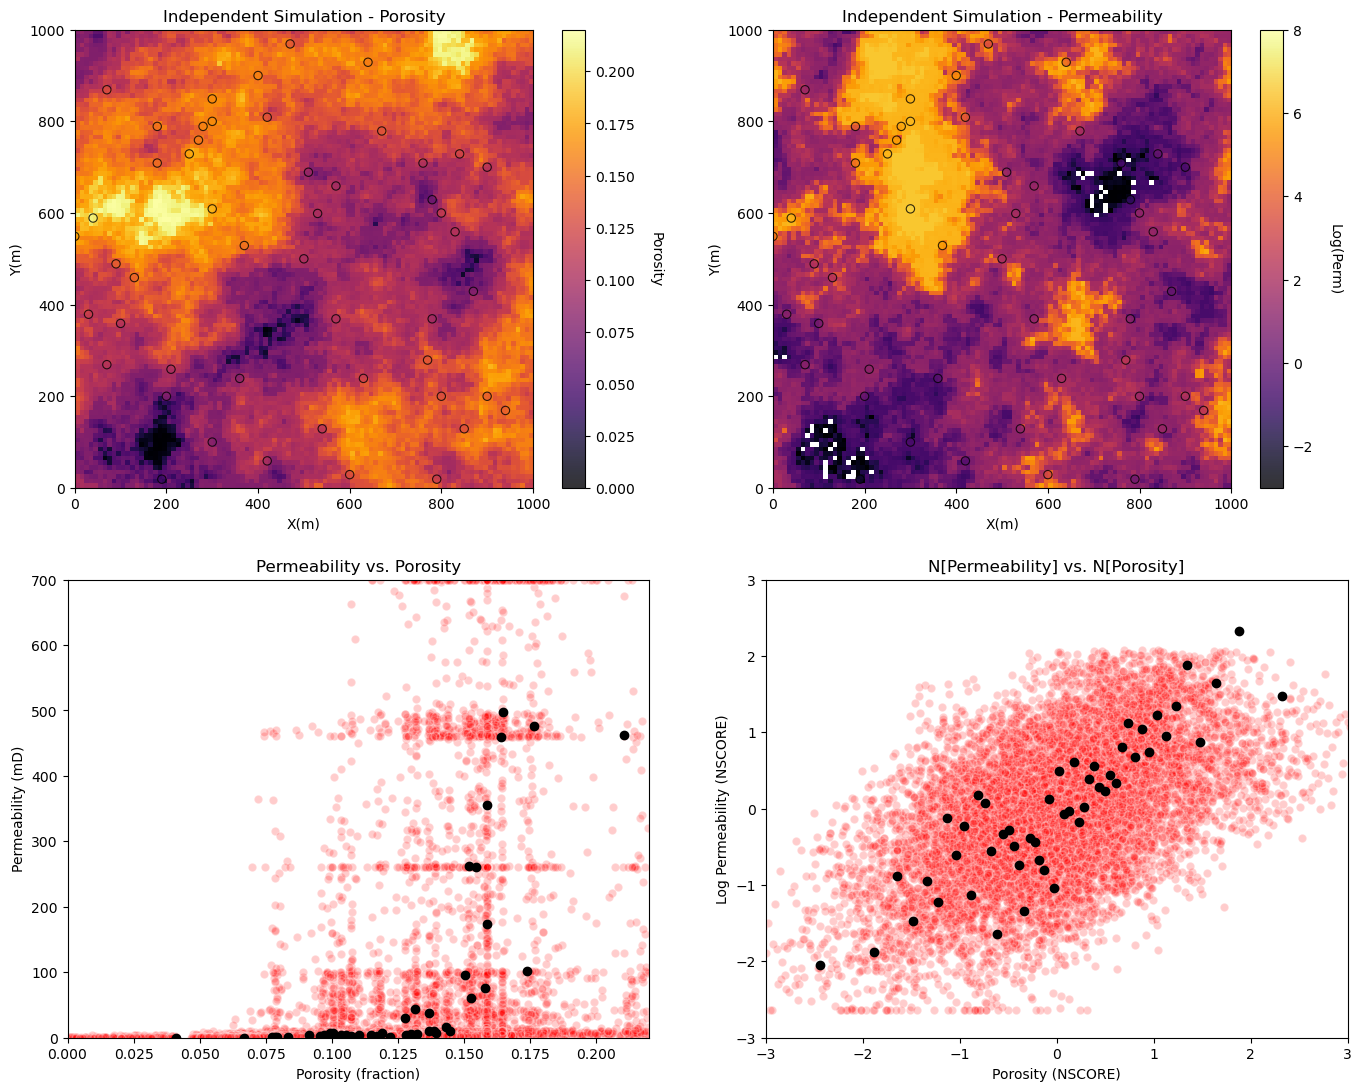

In [10]:
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Independent Simulation - Porosity','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(np.log(sim_perm),xmin,xmax,ymin,ymax,xsiz,logpermmin,logpermmax,df,'X','Y','logPerm','Independent Simulation - Permeability','X(m)','Y(m)','Log(Perm)',cmap)

plt.subplot(223)
plt.scatter(sim_por.flatten(),sim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

sim_npor = geostats.nscore(df=pd.DataFrame(sim_por.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]
sim_nperm = geostats.nscore(df=pd.DataFrame(sim_perm.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]

plt.subplot(224)
plt.scatter(sim_npor,sim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Log Permeability (NSCORE)');plt.title('N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Sequential Gaussian Simulation with Collocated Cokriging

Now let's demonstrate collocated cokriging.  

1. calculate a realization of porosity - DONE - we will use the porosity realization from above! 
2. collocated cokriging realization of permeability constrained to the porosity realization

In [11]:
%%capture --no-display  

cosim_perm = geostats.sgsim(df,'X','Y','Perm',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=1000.0,ltail=1,ltpar=0.0,utail=1,utpar=1000.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
            ktype=4,colocorr=corr,sec_map=sim_por,vario=nperm_vario)[0]

Visualize porosity and permeability realizations and the porosity vs. permeability relationship for independently simulation realizations.

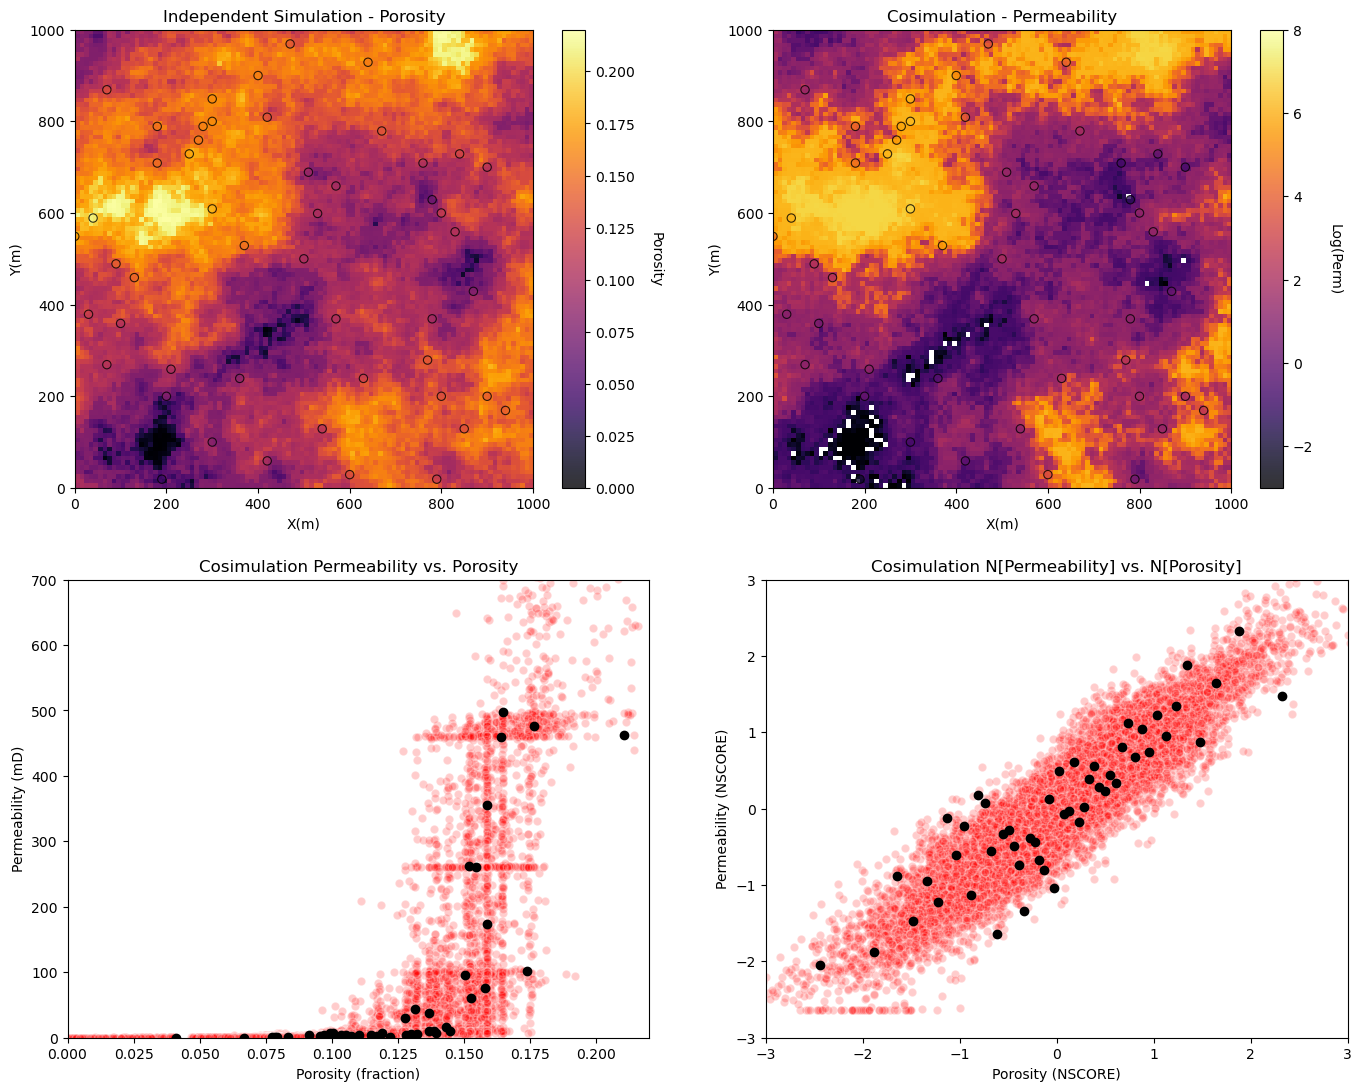

In [12]:
plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Independent Simulation - Porosity','X(m)','Y(m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locpix_st(np.log(cosim_perm),xmin,xmax,ymin,ymax,xsiz,logpermmin,logpermmax,df,'X','Y','logPerm','Cosimulation - Permeability','X(m)','Y(m)','Log(Perm)',cmap)

plt.subplot(223)
plt.scatter(sim_por.flatten(),cosim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Cosimulation Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

sim_npor = geostats.nscore(df=pd.DataFrame(sim_por.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]
cosim_nperm = geostats.nscore(df=pd.DataFrame(cosim_perm.flatten(),columns=['sim_perm']),vcol='sim_perm')[0]

plt.subplot(224)
plt.scatter(sim_npor,cosim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Permeability (NSCORE)');plt.title('Cosimulation N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Compare the Secondary to Primary Relationship

Let's put all the cross plots together.

* **data imposes correlation** - at data and within the variogram range from data, the data correlation is imposed to some degree. This is why we don't see independence between the features with independent simulation.

* **unrealistic combinations** - of features occur with out cosimulation!

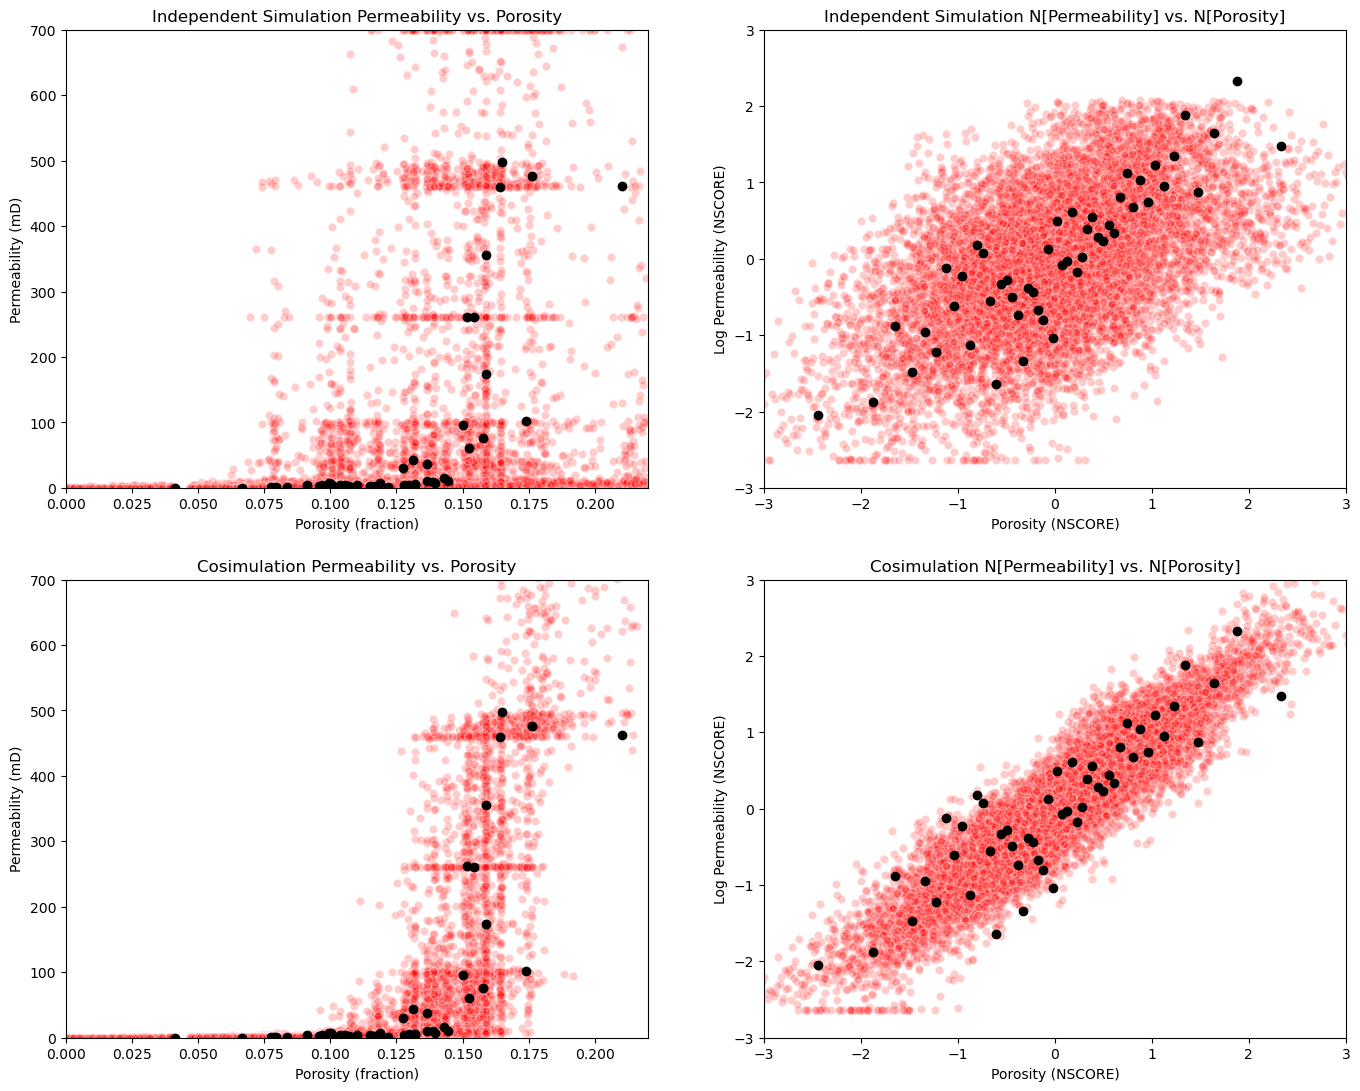

In [13]:
plt.subplot(221)
plt.scatter(sim_por.flatten(),sim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Independent Simulation Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

plt.subplot(222)
plt.scatter(sim_npor,sim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Log Permeability (NSCORE)');plt.title('Independent Simulation N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplot(223)
plt.scatter(sim_por.flatten(),cosim_perm.flatten(),color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['Porosity'].values,df['Perm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Permeability (mD)');plt.title('Cosimulation Permeability vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([permmin,permmax])

plt.subplot(224)
plt.scatter(sim_npor,cosim_nperm,color='red',edgecolor='white',alpha=0.2,zorder=1)
plt.scatter(df['nPorosity'].values,df['nPerm'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (NSCORE)'); plt.ylabel('Log Permeability (NSCORE)');plt.title('Cosimulation N[Permeability] vs. N[Porosity]')
plt.xlim([nsmin,nsmax]); plt.ylim([nsmin,nsmax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration and comparison of cosimulation vs. independent simulation with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)